In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
import datetime
from dateutil import parser
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [3]:
df = pd.read_csv('BNB_TWEET_PROCESSED.csv')

In [4]:
df.head()

,Unnamed: 0,Date,text,likeCount,retweetCount,compound,pos,neg,neu,Twitter_Flair,Twitter_TB_Polarity,Twitter_TB_Subjectivity
0,0,2022-01-01 23:59:12+00:00,@TheMoonCarl @kasta_app @cz_binance Where can ...,1,0,0.000,0.000,0.0,1.000,0.671279,0.0000,0.0
1,1,2022-01-01 23:59:10+00:00,BTC diamond reversal and expected volatility f...,1,0,0.340,0.167,0.0,0.833,-0.894867,-0.1000,0.4
2,2,2022-01-01 23:59:10+00:00,@Dustin62025548 @binance @CEEK,1,0,0.000,0.000,0.0,1.000,0.938796,0.0000,0.0
3,3,2022-01-01 23:58:56+00:00,@MusadiqBabydoge @BabyDogeCoin @cz_binance @el...,1,0,0.658,0.523,0.0,0.477,0.997967,0.9375,0.9
4,4,2022-01-01 23:58:49+00:00,@cz_binance $KDA,3,1,0.000,0.000,0.0,1.000,-0.911692,0.0000,0.0


In [8]:
df1 = pd.read_excel('BNB_CRYPTO.xlsx')
df1.head()

,unix,date,symbol,open,high,low,close,Volume BNB,Volume USDT,tradecount
0,1648681200000,2022-03-30 23:00:00,BNB/USDT,443.1,444.1,441.6,442.1,28447.377,1.260756e+07,11376
1,1648677600000,2022-03-30 22:00:00,BNB/USDT,442.7,443.6,441.0,443.1,20493.516,9.067476e+06,13292
2,1648674000000,2022-03-30 21:00:00,BNB/USDT,446.2,446.3,441.5,442.6,29578.972,1.311486e+07,16727
3,1648670400000,2022-03-30 20:00:00,BNB/USDT,444.8,446.6,444.3,446.2,23738.269,1.057612e+07,14162
4,1648666800000,2022-03-30 19:00:00,BNB/USDT,445.2,445.8,441.8,444.8,35564.184,1.578383e+07,20509


In [9]:
df['date'] = pd.to_datetime(df['Date'])
df['date'] = df['date'].dt.strftime('%y-%m-%d-%H')
df1['date'] = df1['date'].dt.strftime('%y-%m-%d-%H')

In [10]:
#merge = [df,df1]
#merge = pd.concat(merge)
merge = pd.merge(df,df1,on='date')
merge.set_index('date',inplace=True)
merge.sort_values(by='date',inplace=True)

In [12]:
merge.drop('Unnamed: 0',axis=1,inplace=True)
merge.drop('unix',axis=1,inplace=True)
merge.drop('symbol',axis=1,inplace=True)
merge.drop('text',axis=1,inplace=True)
merge.drop('Date',axis=1,inplace=True)
#df.drop('Text',axis=1,inplace=True)

In [13]:
dataset = merge.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#print('dataset.shape', dataset.shape)
num_of_features = len(merge.columns)
print('Number of features', num_of_features)

Number of features 16


In [14]:
expr_name = 'expr_6'
look_back = 24*7 
#lstm_layers = 50
epochs=5
batch_size=128

In [15]:
train_size_percent = 0.70
pred_col = merge.columns.get_loc('close')

# function to split the data
def create_dataset(dataset, pred_col, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, pred_col])
    return np.array(dataX), np.array(dataY)


train_size = int(len(dataset) * train_size_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, pred_col, look_back=look_back)
testX, testY = create_dataset(test, pred_col, look_back=look_back)
# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, num_of_features))
testX = np.reshape(testX, (testX.shape[0],look_back, num_of_features))

print('Training dataset length ', len(train))
print('Testing dataset length ', len(test))
print('look_back ', look_back)

Training dataset length  398997
Testing dataset length  171000
look_back  168


In [ ]:
print(trainX.shape)

In [16]:
model = Sequential()
model.add(LSTM(32,input_shape=(look_back,num_of_features)))
#model.add(LSTM(100,activation='relu',return_sequences=True))
#model.add(LSTM(50,activation='relu',return_sequences=True))
#model.add(LSTM(25,activation='relu'))
#model.add(LSTM(20,activation='relu'))
#model.add(LSTM(10,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.20, epochs=epochs, batch_size=batch_size,shuffle=False)

Epoch 1/5
2493/2493 [==============================] - 178s 71ms/step - loss: 0.0046 - val_loss: 0.0256
Epoch 2/5
2493/2493 [==============================] - 197s 79ms/step - loss: 7.5999e-04 - val_loss: 0.0310
Epoch 3/5
2493/2493 [==============================] - 196s 78ms/step - loss: 9.0485e-04 - val_loss: 0.0315
Epoch 4/5
2493/2493 [==============================] - 196s 79ms/step - loss: 0.0011 - val_loss: 0.0333
Epoch 5/5
2493/2493 [==============================] - 186s 75ms/step - loss: 0.0012 - val_loss: 0.0317


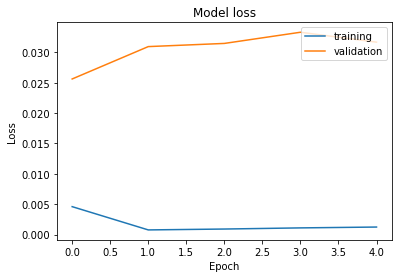

In [17]:
# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training','validation'], loc='upper right')
plt.show()

In [19]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Get something which has as many features as dataset
trainPredict_extended = np.zeros((len(trainPredict),num_of_features))
# Put the predictions there
trainPredict_extended[:,pred_col] = trainPredict[:,0]
# Inverse transform it and select the 3rd column.
trainPredict = scaler.inverse_transform(trainPredict_extended) [:,pred_col]

# Get something which has as many features as dataset
testPredict_extended = np.zeros((len(testPredict),num_of_features))
# Put the predictions there
testPredict_extended[:,pred_col] = testPredict[:,0]
# Inverse transform it and select the pred_col column.
testPredict = scaler.inverse_transform(testPredict_extended)[:,pred_col] 

trainY_extended = np.zeros((len(trainY),num_of_features))
trainY_extended[:,pred_col]=trainY
trainY = scaler.inverse_transform(trainY_extended)[:,pred_col]

testY_extended = np.zeros((len(testY),num_of_features))
testY_extended[:,pred_col]=testY
testY = scaler.inverse_transform(testY_extended)[:,pred_col]

# calculate root mean squared error
trainScore_RMSE = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore_RMSE = math.sqrt(mean_squared_error(testY, testPredict))

# calculate absolute mean error
trainScore_MAE = np.sum(np.absolute(trainY - trainPredict))/len(trainY)
testScore_MAE = np.sum(np.absolute(testY - testPredict))/len(testY)

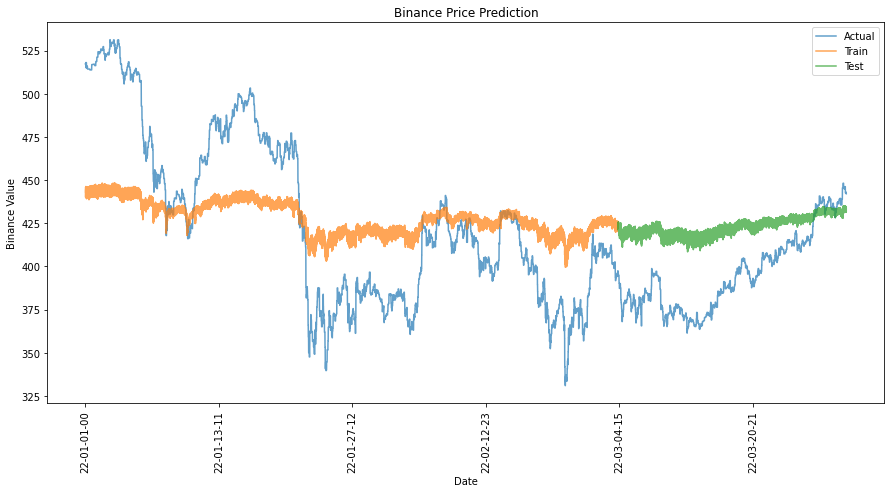

In [20]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, pred_col] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, pred_col] = testPredict

# contruct pandas dataframe for plotting
time_df = pd.DataFrame(merge.index)
time_df['Actual'] = scaler.inverse_transform(dataset)[:,pred_col]
df1 = pd.DataFrame(trainPredictPlot[:,pred_col],columns=['Train'])
df2 = pd.DataFrame(testPredictPlot[:,pred_col],columns=['Test'])
time_df2 = pd.concat([time_df, df1, df2], axis=1, sort=True)
time_df2.set_index('date',inplace=True)

# plot the output
fig, ax = plt.subplots(figsize=(15,7))
time_df2.plot(ax=ax,rot=90,alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Binance Value')
plt.title('Binance Price Prediction')
plt.savefig(expr_name + '.png',bbox_inches = "tight")

In [21]:
print('-' * 100)
print('Experiment name:', expr_name)
print('-' * 100)
print('look_back days:', look_back/24)
#print('lstm_layers:', lstm_layers)
print('epochs:', epochs)
print('batch_size:', batch_size)
print('dataset features', list(merge.columns))
print('-' * 100)
print('Train Score: RMSE: ',(trainScore_RMSE))
print('Test Score: RMSE: ',(testScore_RMSE))
print('-' * 100)
print('Train Score: MAE: ',(trainScore_MAE))
print('Test Score: MAE: ',(testScore_MAE))
print('-' * 100)
print('Model summary:')
model.summary()

----------------------------------------------------------------------------------------------------
Experiment name: expr_6
----------------------------------------------------------------------------------------------------
look_back days: 7.0
epochs: 5
batch_size: 128
dataset features ['likeCount', 'retweetCount', 'compound', 'pos', 'neg', 'neu', 'Twitter_Flair', 'Twitter_TB_Polarity', 'Twitter_TB_Subjectivity', 'open', 'high', 'low', 'close', 'Volume BNB', 'Volume USDT', 'tradecount']
----------------------------------------------------------------------------------------------------
Train Score: RMSE:  40.16442085976452
Test Score: RMSE:  31.874804762082828
----------------------------------------------------------------------------------------------------
Train Score: MAE:  34.1143293748445
Test Score: MAE:  28.283374071174137
----------------------------------------------------------------------------------------------------
Model summary:
Model: "sequential"
___________________